<a href="https://www.kaggle.com/code/jovanagenti/ensemble-nn-90-rf-91-gb-92-rf-91-xgb-92?scriptVersionId=163025129" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.metrics import SparseCategoricalAccuracy
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


2024-02-16 01:43:49.540230: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 01:43:49.540374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 01:43:49.709290: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
dataset_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

# Exploration

**ABBREVIATIONS**

* Frequent consumption of high caloric food (**FAVC**)
 
* Frequency of consumption of vegetables (**FCVC**)

* Number of main meals (**NCP**)
 
* Consumption of food between meals (**CAEC**)
 
* Consumption of water daily (**CH20**)
 
* Consumption of alcohol (**CALC**)

* Calories consumption monitoring (**SCC**)

* Physical activity frequency (**FAF**)

* Time using technology devices (**TUE**)
 
* Transportation used (**MTRANS**)

In [3]:
dataset.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
dataset.drop(labels='id',axis=1, inplace=True)
dataset_test.drop(labels='id',axis=1, inplace=True)

In [5]:
print(f'Training dataset has {dataset.shape[0]} rows and {dataset.shape[1]} columns.')
print(f'Test dataset has {dataset_test.shape[0]} rows and {dataset_test.shape[1]} columns.')

Training dataset has 20758 rows and 17 columns.
Test dataset has 13840 rows and 16 columns.


In [6]:
[print(f'{cat}: \n{pd.unique(dataset[cat])}\n{pd.unique(dataset_test[cat])}') for cat in ['Gender', 'family_history_with_overweight', 
                                                                                          'FAVC', 'CAEC', 'SMOKE', 
                                                                                          'SCC', 'CALC', 'MTRANS']]

Gender: 
['Male' 'Female']
['Male' 'Female']
family_history_with_overweight: 
['yes' 'no']
['yes' 'no']
FAVC: 
['yes' 'no']
['yes' 'no']
CAEC: 
['Sometimes' 'Frequently' 'no' 'Always']
['Sometimes' 'Always' 'Frequently' 'no']
SMOKE: 
['no' 'yes']
['no' 'yes']
SCC: 
['no' 'yes']
['no' 'yes']
CALC: 
['Sometimes' 'no' 'Frequently']
['Sometimes' 'no' 'Frequently' 'Always']
MTRANS: 
['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']
['Public_Transportation' 'Automobile' 'Walking' 'Bike' 'Motorbike']


[None, None, None, None, None, None, None, None]

In [7]:
#Our classes
list(pd.unique(dataset['NObeyesdad']))

['Overweight_Level_II',
 'Normal_Weight',
 'Insufficient_Weight',
 'Obesity_Type_III',
 'Obesity_Type_II',
 'Overweight_Level_I',
 'Obesity_Type_I']

In [8]:
#Checking for null/na/duplicated values
print(pd.notnull(dataset).all().all())
print(pd.notna(dataset).all().all())
print(pd.notnull(dataset_test).all().all())
print(pd.notna(dataset_test).all().all())
print(pd.DataFrame.duplicated(dataset).all())
print(pd.DataFrame.duplicated(dataset_test).all())

True
True
True
True
False
False


In [9]:
dataset.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


<Axes: xlabel='count'>

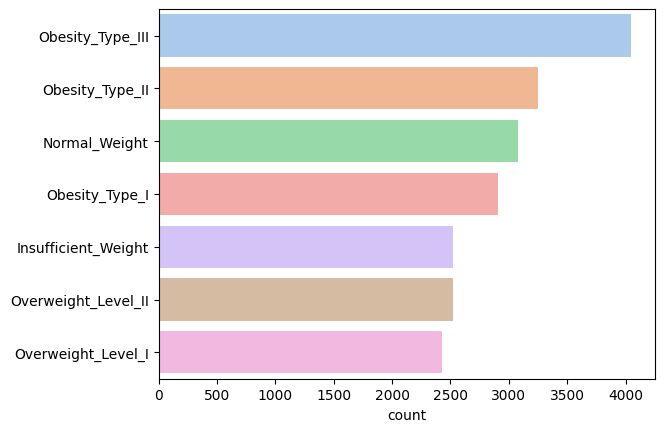

In [10]:
sns.barplot(y=dataset['NObeyesdad'].value_counts().index.values,
            x=dataset['NObeyesdad'].value_counts(), orient='h', palette='pastel')

<Axes: >

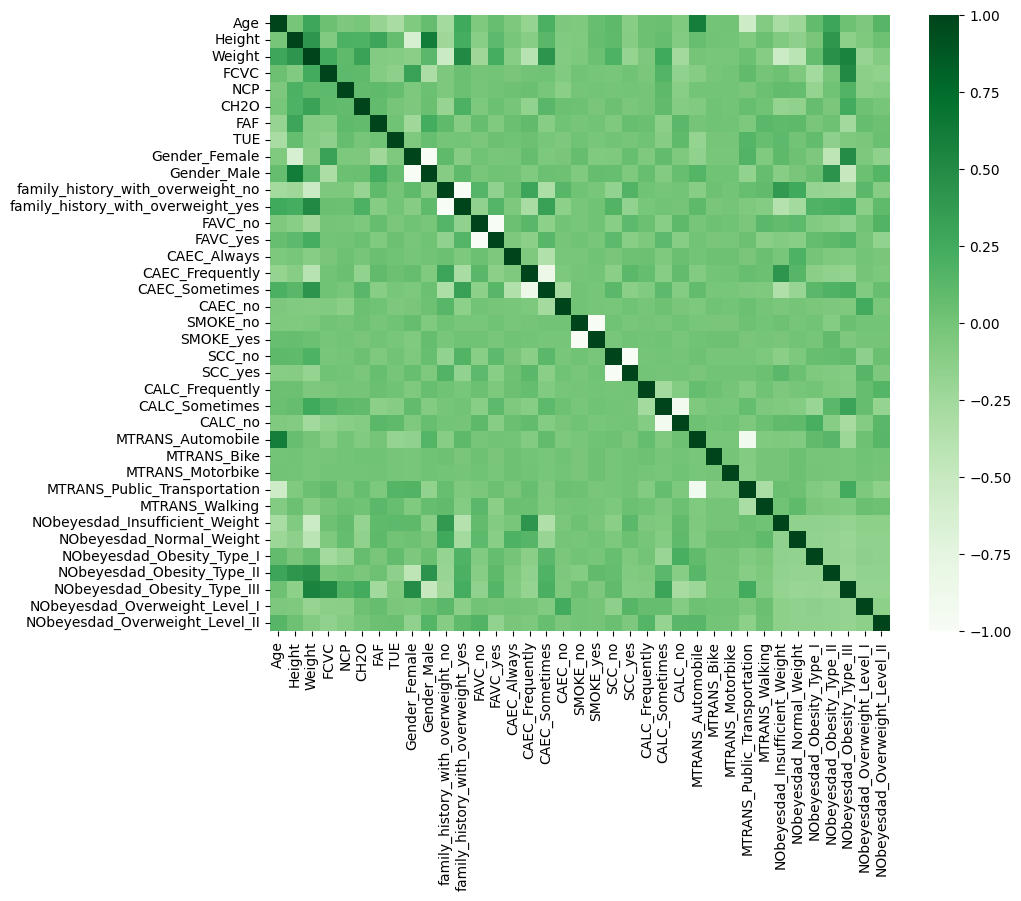

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(pd.get_dummies(dataset).corr(),cmap='Greens',xticklabels=True, yticklabels=True)

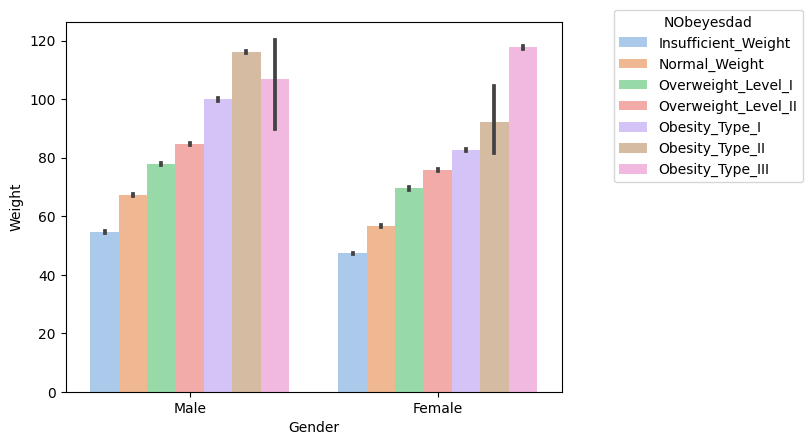

In [12]:
ax = sns.barplot(x=dataset['Gender'],
            y=dataset['Weight'], 
            orient='v', 
            palette='pastel', 
            hue=dataset['NObeyesdad'],
            hue_order=['Insufficient_Weight','Normal_Weight','Overweight_Level_I','Overweight_Level_II','Obesity_Type_I',
                       'Obesity_Type_II', 'Obesity_Type_III'])

sns.move_legend(ax, loc = "center right",bbox_to_anchor=(1.5, 0.8))

# Data processing

In [13]:
def transform_dataset(df, train=True):
    
    #inputs
    if train:
        inputs = df.drop(labels='NObeyesdad',axis=1)
    else:
        inputs = df.copy()
        inputs['CALC'].replace({'Always': 'Frequently'}, inplace=True)

    scaler = StandardScaler()
    numerical_features = inputs.select_dtypes(include=np.number)
    scaled_numerical_features = scaler.fit_transform(numerical_features)
    
    string_features = inputs.select_dtypes(include='object')
    string_features = pd.get_dummies(string_features)
    string_features = string_features.drop(columns = ['Gender_Female','family_history_with_overweight_no','FAVC_no','SMOKE_no','SCC_no',
                                                       'CAEC_no', 'CALC_no', 'MTRANS_Bike'])
    string_features = np.asarray(string_features, dtype = np.float32)
     
    inputs = np.append(scaled_numerical_features, string_features, axis = 1)
    
    #targets
    if train:
        targets = df['NObeyesdad']
        label_encoder = LabelEncoder()
        targets = label_encoder.fit_transform(targets).astype(np.int32)
        
    if train:
        return inputs, targets, label_encoder
    else:
        return inputs

In [14]:
X, Y, le = transform_dataset(dataset)
train_inputs, val_inputs, train_targets, val_targets = train_test_split(X, Y, test_size=0.1, random_state=2409)

In [15]:
print(type(train_inputs), train_inputs.dtype, train_inputs.shape)
print(type(train_targets),train_targets.dtype, train_targets.shape)
print(type(val_inputs),val_inputs.dtype, val_inputs.shape)
print(type(val_targets),val_targets.dtype, val_targets.shape)
print(train_inputs[0])
print(train_targets[range(5)])
print(le.inverse_transform(train_targets[range(5)]))

<class 'numpy.ndarray'> float64 (18682, 22)
<class 'numpy.ndarray'> int32 (18682,)
<class 'numpy.ndarray'> float64 (2076, 22)
<class 'numpy.ndarray'> int32 (2076,)
[-0.77965034 -2.05455665 -1.73956947  1.03917121 -2.49707708 -0.33668576
 -1.17114146  0.40481846  0.          0.          1.          0.
  1.          0.          0.          0.          0.          1.
  0.          0.          1.          0.        ]
[0 2 0 6 6]
['Insufficient_Weight' 'Obesity_Type_I' 'Insufficient_Weight'
 'Overweight_Level_II' 'Overweight_Level_II']


In [16]:
num_classes = len(np.unique(Y))
print(num_classes)

#input shape
input_shape = X.shape[1],
print(input_shape)

7
(22,)


# Model building

# <code style="background:lightgreen;color:black">1. Neural Network</code>

In [17]:
def create_nn_model():
    inputs = Input(input_shape)

    x = Dense(256,'relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005))(inputs)
    x = Dense(256,'relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005))(x)
    x = Dense(256,'relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005))(x)
    x = Dense(256,'relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005))(x)

    outputs = Dense(num_classes,'softmax')(x)
    
    nn_model = Model(inputs, outputs, name = 'Obesity_prediction_model')
    
    return nn_model

In [18]:
nn_model = create_nn_model()

nn_model.summary()

lr_schedule = ExponentialDecay(initial_learning_rate=1e-3,
                                decay_steps= 10000, decay_rate = 0.5, staircase=False)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/checkpoint/',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

nn_model.compile(optimizer=Adam(lr_schedule), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
              metrics = ['accuracy'])

Model: "Obesity_prediction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 22)]              0         
                                                                 
 dense (Dense)               (None, 256)               5888      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 205063 (801.03 KB)
Trainable

In [19]:
results = nn_model.fit(train_inputs, tf.one_hot(train_targets, num_classes),
                       validation_data=(val_inputs, tf.one_hot(val_targets, num_classes)), batch_size=16, epochs=50, verbose=2,
                      callbacks=[model_checkpoint_callback])

Epoch 1/50
1168/1168 - 6s - loss: 1.0288 - accuracy: 0.8088 - val_loss: 0.9306 - val_accuracy: 0.8300 - 6s/epoch - 5ms/step
Epoch 2/50
1168/1168 - 4s - loss: 0.8477 - accuracy: 0.8562 - val_loss: 0.8073 - val_accuracy: 0.8666 - 4s/epoch - 3ms/step
Epoch 3/50
1168/1168 - 4s - loss: 0.8055 - accuracy: 0.8674 - val_loss: 0.8066 - val_accuracy: 0.8719 - 4s/epoch - 4ms/step
Epoch 4/50
1168/1168 - 4s - loss: 0.7824 - accuracy: 0.8743 - val_loss: 0.7962 - val_accuracy: 0.8728 - 4s/epoch - 3ms/step
Epoch 5/50
1168/1168 - 4s - loss: 0.7674 - accuracy: 0.8760 - val_loss: 0.7787 - val_accuracy: 0.8767 - 4s/epoch - 3ms/step
Epoch 6/50
1168/1168 - 3s - loss: 0.7555 - accuracy: 0.8815 - val_loss: 0.7782 - val_accuracy: 0.8685 - 3s/epoch - 3ms/step
Epoch 7/50
1168/1168 - 4s - loss: 0.7471 - accuracy: 0.8847 - val_loss: 0.7698 - val_accuracy: 0.8781 - 4s/epoch - 3ms/step
Epoch 8/50
1168/1168 - 4s - loss: 0.7388 - accuracy: 0.8873 - val_loss: 0.7511 - val_accuracy: 0.8834 - 4s/epoch - 3ms/step
Epoch 9/

In [20]:
print(min(results.history['val_loss']))
print(max(results.history['val_accuracy']))

0.7363463640213013
0.8916184902191162


In [21]:
nn_model = tf.keras.models.load_model('/kaggle/working/checkpoint/')

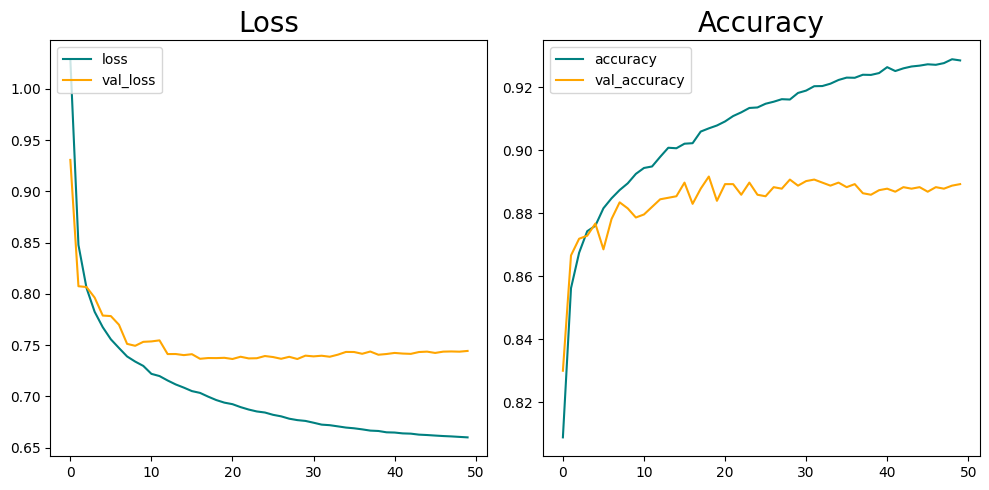

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(results.history['loss'], color='teal', label='loss')
axes[0].plot(results.history['val_loss'], color='orange', label='val_loss')
axes[0].set_title('Loss', fontsize=20)
axes[0].legend(loc="upper left")

# Plotting Accuracy
axes[1].plot(results.history['accuracy'], color='teal', label='accuracy')
axes[1].plot(results.history['val_accuracy'], color='orange', label='val_accuracy')
axes[1].set_title('Accuracy', fontsize=20)
axes[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

In [23]:
nn_model.evaluate(val_inputs, tf.one_hot(val_targets, num_classes))

65/65 [==============================] - 0s 2ms/step - loss: 0.7372 - accuracy: 0.8916


[0.7372297644615173, 0.8916184902191162]

65/65 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'Neural Network')

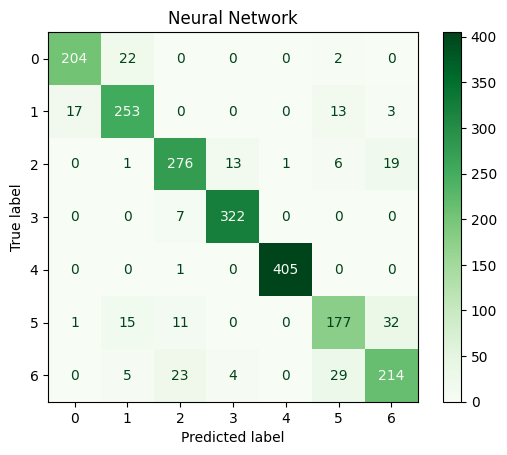

In [24]:
ConfusionMatrixDisplay.from_predictions(val_targets,np.argmax(nn_model.predict(val_inputs), axis = -1),cmap='Greens')
plt.title('Neural Network')

# <code style="background:pink;color:black">2. Logistic Regression</code>

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
logistic_regression_model = LogisticRegression(max_iter=1000).fit(train_inputs, train_targets)
print('Training accuracy: ',logistic_regression_model.score(train_inputs,train_targets))
print('Validation accuracy: ',logistic_regression_model.score(val_inputs,val_targets))

Training accuracy:  0.8664489883310138
Validation accuracy:  0.8588631984585742


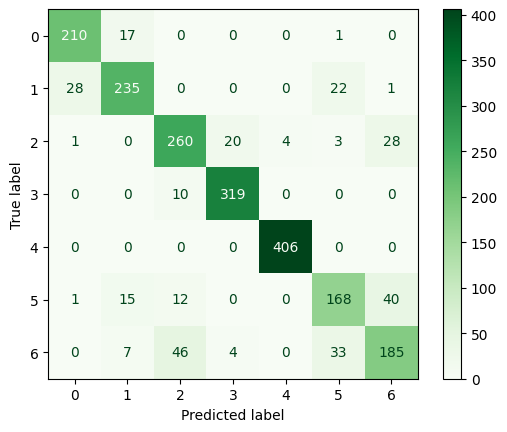

In [27]:
ConfusionMatrixDisplay.from_predictions(val_targets,logistic_regression_model.predict(val_inputs),cmap='Greens')


# <code style="background:pink;color:black">3. Decision Tree</code>

In [28]:
from sklearn.tree import DecisionTreeClassifier

In [29]:
decision_tree_model = DecisionTreeClassifier(criterion='entropy', min_samples_split=120).fit(train_inputs, train_targets)
print('Training accuracy:   ',decision_tree_model.score(train_inputs,train_targets))
print('Validation accuracy: ',decision_tree_model.score(val_inputs,val_targets))

Training accuracy:    0.8851300717267958
Validation accuracy:  0.884393063583815


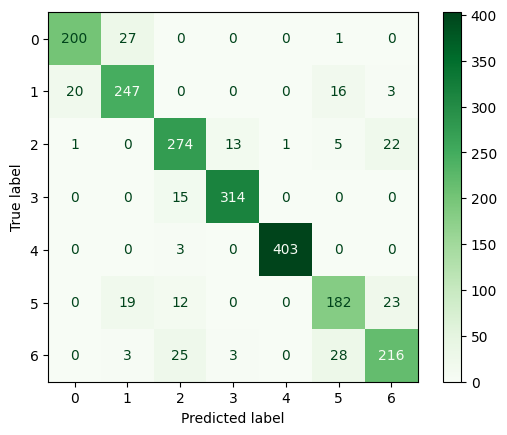

In [30]:
ConfusionMatrixDisplay.from_predictions(val_targets,decision_tree_model.predict(val_inputs),cmap='Greens')


# <code style="background:lightgreen;color:black">4. HistGradientBoosting</code>

In [31]:
from sklearn.ensemble import HistGradientBoostingClassifier

hist_gradient_boosting_model = HistGradientBoostingClassifier(max_iter=100).fit(train_inputs, train_targets)
print('Training accuracy:   ',hist_gradient_boosting_model.score(train_inputs,train_targets),
      ' Validation accuracy: ',hist_gradient_boosting_model.score(val_inputs,val_targets))

Training accuracy:    0.9579274167648003  Validation accuracy:  0.905587668593449


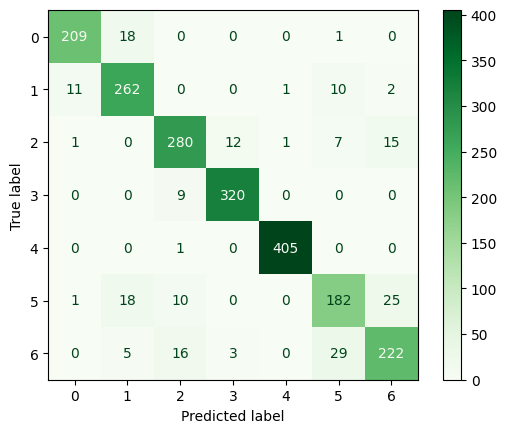

In [32]:
ConfusionMatrixDisplay.from_predictions(val_targets,hist_gradient_boosting_model.predict(val_inputs),cmap='Greens')

# <code style="background:lightgreen;color:black">5. GradientBoosting</code>

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting_model = GradientBoostingClassifier(n_estimators=130).fit(train_inputs, train_targets)
print('Training accuracy:   ',gradient_boosting_model.score(train_inputs,train_targets),
      ' Validation accuracy: ',gradient_boosting_model.score(val_inputs,val_targets))

Training accuracy:    0.9240980623059629  Validation accuracy:  0.9214836223506744


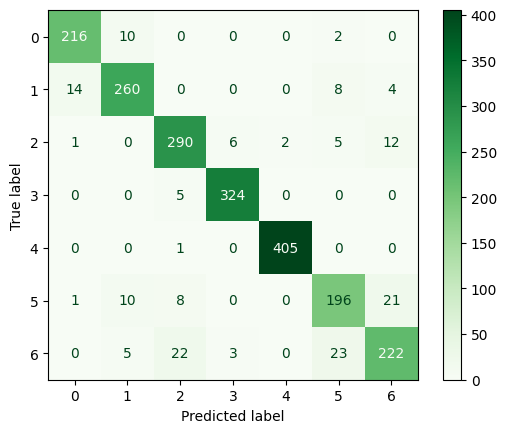

In [34]:
ConfusionMatrixDisplay.from_predictions(val_targets,gradient_boosting_model.predict(val_inputs),cmap='Greens')

# <code style="background:lightgreen;color:black">6. RandomForest</code>

In [35]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(min_samples_split=6 ).fit(train_inputs, train_targets)
print('Training accuracy:   ',random_forest_model.score(train_inputs,train_targets))
print('Validation accuracy: ',random_forest_model.score(val_inputs,val_targets))

Training accuracy:    0.9823894657959533
Validation accuracy:  0.9041425818882466


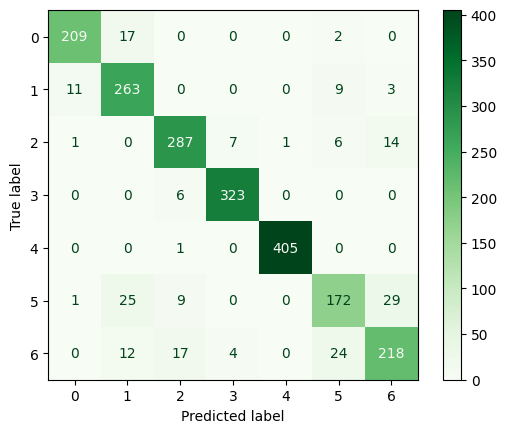

In [36]:
ConfusionMatrixDisplay.from_predictions(val_targets,random_forest_model.predict(val_inputs),cmap='Greens')

# <code style="background:lightgreen;color:black">7. XGboost</code>

In [37]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="multi:softprob").fit(train_inputs, train_targets)
print('Training accuracy:   ',xgb_model.score(train_inputs,train_targets),'\nValidation accuracy: ',xgb_model.score(val_inputs,val_targets))

Training accuracy:    0.9834600149876886 
Validation accuracy:  0.918111753371869


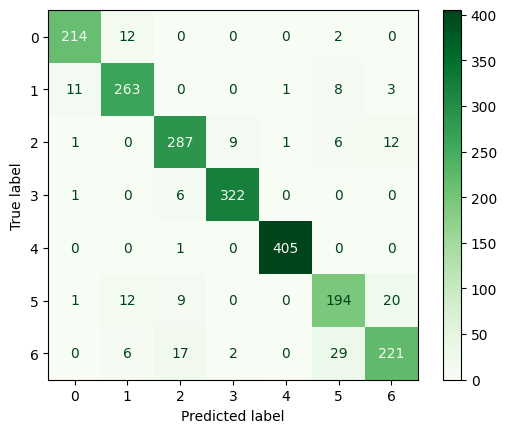

In [38]:
ConfusionMatrixDisplay.from_predictions(val_targets,xgb_model.predict(val_inputs),cmap='Greens')

# Evaluation and Prediction

In [39]:
from sklearn.metrics import accuracy_score

In [40]:
NN = np.argmax(nn_model.predict(val_inputs),axis=-1)
HGB = hist_gradient_boosting_model.predict(val_inputs)
GB = gradient_boosting_model.predict(val_inputs)
RF = random_forest_model.predict(val_inputs)
XGB =xgb_model.predict(val_inputs)

65/65 [==============================] - 0s 2ms/step


In [41]:
# List of all possible model combinations
import itertools
def get_combinations(lst):
    combination = []
    for r in range(1, len(lst) + 1):
        
        # to generate combination
        combination.extend(itertools.combinations(lst, r))
    return combination
objects = [NN,HGB,RF,GB,XGB] 
all_combinations = get_combinations(objects)
print(len(all_combinations))

31


In [42]:
# Printing validation data accuracies for each combination
acc=np.array([])
for combination in all_combinations:
    stacked = np.stack(combination,axis=1)
    predictions=[]
    for i in stacked:
        predictions = predictions+[np.bincount(i).argmax()]
    acc = np.append(acc,accuracy_score(val_targets,predictions))
    print(accuracy_score(val_targets,predictions))

0.8916184971098265
0.905587668593449
0.9041425818882466
0.9214836223506744
0.918111753371869
0.8988439306358381
0.8959537572254336
0.9108863198458574
0.9065510597302505
0.905587668593449
0.9137764932562621
0.9137764932562621
0.9113680154142582
0.9084778420038536
0.9176300578034682
0.9094412331406551
0.9157032755298651
0.9128131021194605
0.9137764932562621
0.9152215799614644
0.9219653179190751
0.9152215799614644
0.9128131021194605
0.9171483622350675
0.9195568400770713
0.9132947976878613
0.9123314065510597
0.918111753371869
0.9176300578034682
0.9137764932562621
0.9185934489402697


In [43]:
X_test = transform_dataset(dataset_test,train=False)

/tmp/ipykernel_18/1051296629.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inputs['CALC'].replace({'Always': 'Frequently'}, inplace=True)


In [44]:
RF_test_pred = random_forest_model.predict(X_test)
GB_test_pred = gradient_boosting_model.predict(X_test)
XGB_test_pred = xgb_model.predict(X_test)

In [45]:
final_predictions = []
stacked_test = np.stack([RF_test_pred,GB_test_pred,XGB_test_pred],axis=1)
final_predictions=[]
for i in stacked_test:
    final_predictions = final_predictions+[np.bincount(i).argmax()]

In [46]:
print(final_predictions[:5])
print(le.inverse_transform(final_predictions[:5]))

[3, 5, 4, 2, 4]
['Obesity_Type_II' 'Overweight_Level_I' 'Obesity_Type_III'
 'Obesity_Type_I' 'Obesity_Type_III']


In [47]:
sub = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

In [48]:
submission = pd.DataFrame({'id': sub['id'], 'NObeyesdad': le.inverse_transform(final_predictions)})

print(submission.head())

      id          NObeyesdad
0  20758     Obesity_Type_II
1  20759  Overweight_Level_I
2  20760    Obesity_Type_III
3  20761      Obesity_Type_I
4  20762    Obesity_Type_III


In [49]:
submission.to_csv('submission.csv', index=False)